# CheXpert Dataset - Download and Data Preparation

This notebook shows how to download and preprocess the CheXpert dataset for further analysis with gradient matching. The CheXpert training set is composed of chest radiographs, which were annotated on the basis of reports using the rule-based CheXpert labeler. Each image is labeled with respect 12 pathologies as well as the observations "No Finding" and "Support Devices". For each of these categories, except "No Finding", the assigned weak label is either positive (1.0), negative (0.0), not mentioned (blank) or uncertain (-1.0). The development set was annotated by radiologists and therefore only contains the binary labels positive (1.0) and negative (0.0). (Irvin et al. (2019))

You can register for obtaining the data under the following link: https://stanfordmlgroup.github.io/competitions/chexpert/. Once the registration is finished, you should receive an email which contains links for two different versions of the dataset, the original CheXpert dataset (around 439 GB) and a version with downsampled resolution (around 11 GB). The code below uses the downsampled version. Please unzip the downloaded folder in a directory of your choice and don't change the filenames or the folder structure, otherwise you might need to change some of the paths used in the following code in order for it to run properly. The zip file you obtained should contain a training and a validation set. The CheXpert test set is not publicly available, as it is used for the CheXpert competition (see link above). The reports that were used to label the images are also unavailable.

# Imports

First, let's import the required packages.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import os
import torchvision.transforms as transforms
import joblib
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from tabulate import tabulate

# Loading the dataset

Now, let's load the files train.csv and valid.csv, which accompany the images. First, please change the working directory to the appropriate location by inserting the path to the folder in which you stored train.csv and valid.csv where PATH is mentioned in the code. If you didn't change the folder structure, this path should end with "\CheXpert-v1.0-small\CheXpert-v1.0-small".

In [2]:
path = PATH
os.chdir(path) #change working directory to appropriate location

training_set = pd.read_csv("train.csv")

validation_set = pd.read_csv("valid.csv")

Let's take a look at the first five rows of the raw training data.

In [3]:
training_set.head(5)

,Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices
0,CheXpert-v1.0-small/train/patient00001/study1/...,Female,68,Frontal,AP,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,1.0
1,CheXpert-v1.0-small/train/patient00002/study2/...,Female,87,Frontal,AP,NaN,NaN,-1.0,1.0,NaN,-1.0,-1.0,NaN,-1.0,NaN,-1.0,NaN,1.0,NaN
2,CheXpert-v1.0-small/train/patient00002/study1/...,Female,83,Frontal,AP,NaN,NaN,NaN,1.0,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN
3,CheXpert-v1.0-small/train/patient00002/study1/...,Female,83,Lateral,NaN,NaN,NaN,NaN,1.0,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN
4,CheXpert-v1.0-small/train/patient00003/study1/...,Male,41,Frontal,AP,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN


As can be seen, each observation in the training set consists of a path to an image, some additional information about the patient and the nature of the image, as well as the weak labels for all 14 classes. 12 of the classes, "Enlarged Cardiomediastinum" to "Fracture", are considered pathologies. "No Finding" is assigned the label 1 (meaning "positive") if no pathology was marked as positive (1.0) or uncertain (-1.0) for this observation. Labels which were blank (meaning that the pathology was not mentioned in the report) turned into NaNs when loading the data. The training set has a total of 223414 observations. (Irvin et al. (2019))

For comparison, let's also have a look at the validation set.

In [4]:
validation_set.head(5)

,Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices
0,CheXpert-v1.0-small/valid/patient64541/study1/...,Male,73,Frontal,AP,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,CheXpert-v1.0-small/valid/patient64542/study1/...,Male,70,Frontal,PA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,CheXpert-v1.0-small/valid/patient64542/study1/...,Male,70,Lateral,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,CheXpert-v1.0-small/valid/patient64543/study1/...,Male,85,Frontal,AP,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,CheXpert-v1.0-small/valid/patient64544/study1/...,Female,42,Frontal,AP,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


As you can see, the validation set has the same structure as the training set. However, the validation set only uses positive (1.0) and negative (0.0) labels and no uncertainty (-1.0) or not-mentioned labels (blank). The validation set contains 234 observations.

In the following, some statistics are computed in order to get an idea about the label distribution in the two datasets.

In [5]:
training_labels = training_set.iloc[:, -13:-1]
labels_per_row = training_labels.count(axis = 1) #number of non-NaN labels per row in the training set

vals = pd.DataFrame(labels_per_row.value_counts())

#make a table
val_list = []
for i in vals.index:
    val_list.append([i, vals[0][i]])
    
print(tabulate(val_list, headers = ["Number of non-NaN labels", "Number of datapoints"]))

  Number of non-NaN labels    Number of datapoints
--------------------------  ----------------------
                         3                   64386
                         4                   50893
                         2                   50672
                         5                   23828
                         1                   23185
                         6                    7922
                         7                    1960
                         8                     294
                         0                     250
                         9                      19
                        10                       5


As can be seen, most training samples have at least a few pathologies, for which they have a label which is not blank, meaning it is either positive (1.0), negative (0.0) or uncertain (-1.0). Nevertheless, there seem to be 250 observations for which none of the 12 pathologies were mentioned in the corresponding report.

The following two tables should give an idea about the label distribution for the different pathologies in the training set and in the validation set.

In [6]:
val_list = []
for cond in training_labels.columns:
    vals = np.array(training_labels.value_counts(subset=[cond]).sort_index(ascending = True))
    val_list.append([cond, vals[0], vals[1], vals[2]])

print("Label distribution in the training set:", "\n")
print(tabulate(val_list, headers = ["Pathology", "-1.0", "0.0", "1.0"]))

Label distribution in the training set: 

Pathology                     -1.0    0.0     1.0
--------------------------  ------  -----  ------
Enlarged Cardiomediastinum   12403  21638   10798
Cardiomegaly                  8087  11116   27000
Lung Opacity                  5598   6599  105581
Lung Lesion                   1488   1270    9186
Edema                        12984  20726   52246
Consolidation                27742  28097   14783
Pneumonia                    18770   2799    6039
Atelectasis                  33739   1328   33376
Pneumothorax                  3145  56341   19448
Pleural Effusion             11628  35396   86187
Pleural Other                 2653    316    3523
Fracture                       642   2512    9040


In [7]:
validation_labels = validation_set.iloc[:, -13:-1]

val_list = []
for cond in validation_labels.columns:
    vals = np.array(validation_labels.value_counts(subset=[cond]).sort_index(ascending=True))
    if cond != "Fracture":
        val_list.append([cond, vals[0], vals[1]])
    else:
        val_list.append([cond, vals[0], 0]) #fracture never positively appears in validation set
        
print("Label distribution in the validation set:", "\n")
print(tabulate(val_list, headers = ["Pathology", "0.0", "1.0"]))

Label distribution in the validation set: 

Pathology                     0.0    1.0
--------------------------  -----  -----
Enlarged Cardiomediastinum    125    109
Cardiomegaly                  166     68
Lung Opacity                  108    126
Lung Lesion                   233      1
Edema                         189     45
Consolidation                 201     33
Pneumonia                     226      8
Atelectasis                   154     80
Pneumothorax                  226      8
Pleural Effusion              167     67
Pleural Other                 233      1
Fracture                      234      0


As can be seen, some observations like "Fracture" or "Lung Lesion" are positively mentioned (i.e. label 1.0) for numerous observations in the training set, however, they either barely appear or don't appear at all in the validation set.

Now that we have familiarized ourselves with the labels in the training and in the validation set, let's take a look at an example image from the training set.

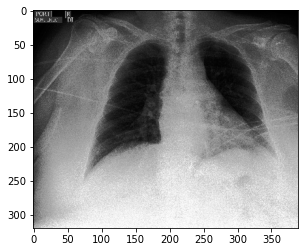

Dimensions of image: (389, 320)


In [8]:
image_paths = path[: path.find("CheXpert-v1.0-small")] + "CheXpert-v1.0-small/" + training_set["Path"]

sample_image = Image.open(image_paths[0]).convert('RGB')
plt.imshow(sample_image)
plt.show()
print("Dimensions of image:", sample_image.size)

All images in the (downsampled) dataset have a dimensionality of around 390 x 320 pixels, however, the individual image sizes vary. (Garbin et al. (2021))

In the following, a transform sequence is defined, which will be used to preprocess the images. The images are first resized to 320 x 320 pixels and then normalized with the mean and standard deviation from ImageNet. Such transformations have previously been applied by several other submissions regarding CheXpert on github such as:
https://github.com/gaetandi/cheXpert/blob/master/cheXpert_final.ipynb and https://github.com/Stomper10/CheXpert/blob/master/CheXpert_DenseNet121_FL.ipynb

In [9]:
transform_list = transforms.Compose([
    transforms.Resize((320, 320)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) #normalization from ImageNet
    ])

The following class will be used to transform the images and prepare the dataset for PyTorch's DataLoader. Moreover, the uncertainty labels will be handled according to either the "U-Ones", "U-Zeroes", "U-Ignore" or "U-MultiClass" approach as they were described in the origianl CheXpert paper by Irvin et al. (2019). You can specify how the uncertainty labels for each individual pathology will be handled by providing a list of the names of the pathologies to the arguments to_ones, to_zeros and to_ignore. to_ignore changes the uncertainty label (-1.0) to nan. Not specifying any pathology in any of the arguments to_ones, to_zeros or to_ignore will train the model with the "U-MultiClass" approach. The "Support Device" label as well as the "No Finding" label is dropped for all instances, since support devices do not count as pathologies and the "No Finding" label only depends on the labels for the remaining 12 pathologies. The "blank" labels, indicating that an observation was not mentioned in the corresponding report, will be treated as "uncertain". The validation set can be loaded by setting the subset input of the class to "valid".

The structure of the class was inspired by the github submissions credited above.

In [10]:
class prepare_CheXpert(Dataset):
    
    def __init__(self, path, subset = "train", to_ones = None, to_zeros = None, to_ignore = None, transform_sequence = None):
        
        """
        path: path to the folder where train.csv and valid.csv are stored
        subset: either "train" to load the train.csv or "valid" to load valid.csv
        to_ones: list of pathologies for which uncertainty labels should be replaced by 1
        to_zeros: list of pathologies for which uncertainty labels should be replaced by 0
        to_ignore: list of pathologies for which uncertainty labels should be ignored (label will be turned to nan)
        transform_sequence: sequence used to transform the images
        """
        
        #read dataset
        if subset == "train":
            data = pd.read_csv("train.csv")
            
        elif subset == "valid":
            data = pd.read_csv("valid.csv")
            
        else:
            raise ValueError("Invalid subset, please choose either 'train' or 'valid'")
            
        pathologies = data.iloc[:, -13:-1].columns
        
        #prepare labels
        data.iloc[:, -13:-1] = data.iloc[:, -13:-1].replace(float("nan"), -1) #blank labels -> uncertain
        
        if to_ones is not None:
            if all(p in pathologies for p in to_ones): #check whether arguments are valid pathologies
                data[to_ones] = data[to_ones].replace(-1, 1) #replace uncertainty labels with ones
            else:
                raise ValueError("List supplied to to_ones contains invalid pathology, please choose from:",
                                 list(pathologies))
            
        if to_zeros is not None:
            if all(p in pathologies for p in to_zeros):
                data[to_zeros] = data[to_zeros].replace(-1, 0) #replace uncertainty labels with zeros
            else:
                raise ValueError("List supplied to to_zeros contains invalid pathology, please choose from:",
                                 list(pathologies))
            
        if to_ignore is not None:
            if all(p in pathologies for p in to_ignore):
                data[to_ignore] = data[to_ignore].replace(-1, float("nan")) #replace uncertainty labels with nan
            else:
                raise ValueError("List supplied to to_ignore contains invalid pathology, please choose from:",
                                 list(pathologies))
        
        #path to access the pictures (for small dataset)
        image_paths = path[: path.find("CheXpert-v1.0-small")] + "CheXpert-v1.0-small/" + data["Path"]
        
        number_of_images = len(data)
            
        self.image_paths = image_paths
        self.number_of_images = number_of_images
        self.transform_sequence = transform_sequence
        self.data = data
    
    def __getitem__(self, index = None):
        
        """
        index: index of example that should be retrieved
        """
        
        image_name = self.image_paths[index]
        
        image_labels = self.data.iloc[index, -13:-1]
        
        patient_image = Image.open(image_name).convert('RGB')
        
        if self.transform_sequence is not None:
            patient_image = self.transform_sequence(patient_image) #apply the transform_sequence if one is specified
        
        else:
            #even if no other transformation is applied, the image should be turned into a tensor
            to_tensor = transforms.ToTensor()
            patient_image = to_tensor(patient_image)
        
        return patient_image, torch.tensor(image_labels)
    
    def __len__(self):
        return self.number_of_images

In [11]:
chexpert_train = prepare_CheXpert(path, transform_sequence = transform_list)
chexpert_valid = prepare_CheXpert(path, subset = "valid", transform_sequence = transform_list)

For a given index, the getitem function returns the tensor representing the preprocessed image as well as a tensor containing all of the labels for this observation.
Let's take a look at what getitem returns for the training example with index 0.

In [12]:
chexpert_train.__getitem__(0)

(tensor([[[-2.1008, -1.8097, -1.2788,  ..., -2.1179, -2.1179, -2.1179],
          [-2.0665, -1.7925, -1.2617,  ..., -2.1008, -2.1008, -2.1008],
          [-2.1179, -1.8097, -1.2445,  ..., -2.1008, -2.1179, -2.1179],
          ...,
          [ 0.6049,  0.8104,  0.8447,  ...,  1.9064,  1.7865,  1.9235],
          [ 0.7419,  0.7762,  0.7591,  ...,  2.1975,  2.0263,  1.9749],
          [ 0.9817,  1.0502,  0.8276,  ...,  2.0434,  1.9407,  1.8208]],
 
         [[-2.0182, -1.7206, -1.1779,  ..., -2.0357, -2.0357, -2.0357],
          [-1.9832, -1.7031, -1.1604,  ..., -2.0182, -2.0182, -2.0182],
          [-2.0357, -1.7206, -1.1429,  ..., -2.0182, -2.0357, -2.0357],
          ...,
          [ 0.7479,  0.9580,  0.9930,  ...,  2.0784,  1.9559,  2.0959],
          [ 0.8880,  0.9230,  0.9055,  ...,  2.3761,  2.2010,  2.1485],
          [ 1.1331,  1.2031,  0.9755,  ...,  2.2185,  2.1134,  1.9909]],
 
         [[-1.7870, -1.4907, -0.9504,  ..., -1.8044, -1.8044, -1.8044],
          [-1.7522, -1.4733,

In [13]:
shape_of_image_tensor = chexpert_train.__getitem__(0)[0].shape
shape_of_label_tensor = chexpert_train.__getitem__(0)[1].shape

print("Shape of image tensor:", shape_of_image_tensor)
print("Shape of label tensor:", shape_of_label_tensor)

Shape of image tensor: torch.Size([3, 320, 320])
Shape of label tensor: torch.Size([12])


# Storing the preprocessed data

The tensors representing the preprocessed images and the tensors containing the labels can be stored on your computer using joblib. If you want to do this, you can run the following code but please be aware that the resulting joblib files might become very large, especially for the training data.

In [14]:
filename = 'chexpert_data_train.joblib'
outfile = open(filename,'wb')

for i in tqdm(range(0, training_set.shape[0])):
    joblib.dump(chexpert_train.__getitem__(i), outfile)
    
filename = 'chexpert_data_valid.joblib'
outfile = open(filename,'wb')

for i in tqdm(range(0, validation_set.shape[0])):
    joblib.dump(chexpert_valid.__getitem__(i), outfile)

100%|██████████| 234/234 [00:01<00:00, 180.44it/s]


This concludes the preprocessing of the CheXpert data.

# References

CheXpert: A large chest radiograph dataset with uncertainty labels and expert comparison by Irvin et al. (2019):
https://arxiv.org/abs/1901.07031

Structured dataset documentation: a datasheet for CheXpert by Garbin et al. (2021):
https://arxiv.org/pdf/2105.03020.pdf